In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

# Load Data
X_train_labeled = pd.read_csv("./task3/training_data_set_13_labeled_data.csv").values
y_train_labels = pd.read_csv("./task3/training_data_set_13_labeled_labels.csv").values.flatten()
X_train_unlabeled = pd.read_csv("./task3/training_data_set_13_unlabeled.csv").values
X_test = pd.read_csv("./task3/testing_data_set_13_data.csv").values
y_test_labels = pd.read_csv("./task3/testing_data_set_13_labels.csv").values.flatten()
X_val = pd.read_csv("./task3/validation_data_set_13_data.csv").values
y_val_labels = pd.read_csv("./task3/validation_data_set_13_labels.csv").values.flatten()

# Convert to PyTorch tensors
X_train_labeled = torch.FloatTensor(X_train_labeled)
y_train_labels = torch.LongTensor(y_train_labels)
X_train_unlabeled = torch.FloatTensor(X_train_unlabeled)
X_test = torch.FloatTensor(X_test)
y_test_labels = torch.LongTensor(y_test_labels)
X_val = torch.FloatTensor(X_val)
y_val_labels = torch.LongTensor(y_val_labels)


# Define Dimensions
input_dim = X_train_unlabeled.shape[1]  # Assuming input_dim = 36
hidden_dims = [28, 20, 12]  # Ensure correct shape transitions
output_dim = len(set(y_train_labels.numpy()))  # Number of classes
print(output_dim)
print(input_dim)

5
36


In [2]:
# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, l1, j1 , l2):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(l1, j1),
            nn.Tanh(),
            nn.Linear(j1, l2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(l2, j1),
            nn.Tanh(),
            nn.Linear(j1, l1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

def train_autoencoder(model, data, epochs=100, min_batches=10, lr=0.001, threshold=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=len(data)//min_batches, shuffle=True)

    prev_loss = float('inf')
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            _, reconstructed = model(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")
        
        # Stopping criterion: if change in loss is below threshold
        if abs(prev_loss - avg_loss) < threshold:
            print("Stopping early due to small loss change.")
            break
        prev_loss = avg_loss

    return model.encoder  # Return the trained encoder


In [3]:
# Train Autoencoders Sequentially
encoder1 = train_autoencoder(Autoencoder(input_dim, (input_dim + hidden_dims[0]) // 2, hidden_dims[0]), X_train_unlabeled)
encoded1 = encoder1(torch.tensor(X_train_unlabeled, dtype=torch.float32)).detach()

encoder2 = train_autoencoder(Autoencoder(hidden_dims[0], (hidden_dims[0] + hidden_dims[1]) // 2, hidden_dims[1]), encoded1)
encoded2 = encoder2(torch.tensor(encoded1, dtype=torch.float32)).detach()

encoder3 = train_autoencoder(Autoencoder(hidden_dims[1], (hidden_dims[1] + hidden_dims[2]) // 2, hidden_dims[2]), encoded2)
encoded3 = encoder3(torch.tensor(encoded2, dtype=torch.float32)).detach()

C:\Users\Shreyas_new_laptop\AppData\Local\Temp\ipykernel_24232\2522261797.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))


Epoch 1/100, Loss: 0.03537810712375424
Epoch 2/100, Loss: 0.019378604960035194
Epoch 3/100, Loss: 0.0093641026284207
Epoch 4/100, Loss: 0.006100491578267379
Epoch 5/100, Loss: 0.005637341263619336
Epoch 6/100, Loss: 0.0053963977843523026
Epoch 7/100, Loss: 0.005298930008641698
Stopping early due to small loss change.


C:\Users\Shreyas_new_laptop\AppData\Local\Temp\ipykernel_24232\2988063140.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded1 = encoder1(torch.tensor(X_train_unlabeled, dtype=torch.float32)).detach()


Epoch 1/100, Loss: 0.0557841377502138
Epoch 2/100, Loss: 0.02771570821377364
Epoch 3/100, Loss: 0.010680871973322197
Epoch 4/100, Loss: 0.0033721379745243626
Epoch 5/100, Loss: 0.001186019111297686
Epoch 6/100, Loss: 0.0008714804214171388
Epoch 7/100, Loss: 0.0007486248240721496
Epoch 8/100, Loss: 0.0007204726518301123
Stopping early due to small loss change.


C:\Users\Shreyas_new_laptop\AppData\Local\Temp\ipykernel_24232\2988063140.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded2 = encoder2(torch.tensor(encoded1, dtype=torch.float32)).detach()


Epoch 1/100, Loss: 0.12164268574931404
Epoch 2/100, Loss: 0.08130054853179237
Epoch 3/100, Loss: 0.0462190793319182
Epoch 4/100, Loss: 0.02033112037249587
Epoch 5/100, Loss: 0.00867199186574329
Epoch 6/100, Loss: 0.0038234261922876944
Epoch 7/100, Loss: 0.0011885588226670568
Epoch 8/100, Loss: 0.0003552247733089396
Epoch 9/100, Loss: 0.00013495340482966805
Epoch 10/100, Loss: 0.0001012722654691474
Stopping early due to small loss change.


C:\Users\Shreyas_new_laptop\AppData\Local\Temp\ipykernel_24232\2988063140.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded3 = encoder3(torch.tensor(encoded2, dtype=torch.float32)).detach()


In [4]:
# Define Stacked Encoder
class StackedEncoder(nn.Module):
    def __init__(self, encoder1, encoder2, encoder3):
        super(StackedEncoder, self).__init__()
        self.encoder1 = encoder1
        self.encoder2 = encoder2
        self.encoder3 = encoder3

    def forward(self, x):
        x = self.encoder1(x)
        x = self.encoder2(x)
        x = self.encoder3(x)
        return x

stacked_encoder = StackedEncoder(encoder1, encoder2, encoder3)

In [5]:
# Define Final DFNN Model
class PretrainedDFNN(nn.Module):
    def __init__(self, stacked_encoder, output_dim):
        super(PretrainedDFNN, self).__init__()
        self.encoder = stacked_encoder
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dims[-1], output_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)


In [12]:
def train_dfnn(model, X_train, y_train, epochs=100, min_batches=10, lr=0.001, threshold=5*1e-6):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    dataloader = DataLoader(dataset, batch_size=len(X_train)//min_batches, shuffle=True)

    prev_loss = float('inf')
    total_epochs=0
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        #print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

        # Stopping criterion: if change in loss is below threshold
        if abs(prev_loss - avg_loss) < threshold:
            print("Stopping early due to small loss change.")
            break
        prev_loss = avg_loss
        total_epochs= epoch
    print(prev_loss)
    print(total_epochs)
    

In [13]:
# Initialize and Train Final Model
pretrained_model = PretrainedDFNN(stacked_encoder, output_dim)
train_dfnn(pretrained_model, X_train_labeled, y_train_labels,epochs=5000,lr=0.005)



C:\Users\Shreyas_new_laptop\AppData\Local\Temp\ipykernel_24232\2471862279.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))


0.8461504632776434
4999


In [8]:
class DFNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(DFNN, self).__init__()
        
        # Matching the stacked autoencoder structure
        j1 = (input_dim + hidden_dims[0]) // 2
        j2 = (hidden_dims[0] + hidden_dims[1]) // 2
        j3 = (hidden_dims[1] + hidden_dims[2]) // 2

        self.model = nn.Sequential(
            nn.Linear(input_dim, j1),
            nn.Tanh(),
            nn.Linear(j1, hidden_dims[0]),
            
            nn.Linear(hidden_dims[0], j2),
            nn.Tanh(),
            nn.Linear(j2, hidden_dims[1]),
            
            nn.Linear(hidden_dims[1], j3),
            nn.Tanh(),
            nn.Linear(j3, hidden_dims[2]),
            
            nn.Linear(hidden_dims[2], output_dim)  # Softmax for multi-class classification
        )

    def forward(self, x):
        return self.model(x)

def train_dfnn(model, X_train, y_train, epochs=5000, min_batches=10, lr=0.001, threshold=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    dataloader = DataLoader(dataset, batch_size=len(X_train)//min_batches, shuffle=True)

    prev_loss = float('inf')
    epo=0
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        #print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

        # Stopping criterion: if change in loss is below threshold
        if abs(prev_loss - avg_loss) < threshold:
            print("Stopping early due to small loss change.")
            break
        prev_loss = avg_loss
        epo=epoch
    print(prev_loss)
    print(epo)

# Evaluation function
def evaluate_dfnn(model, X_test, y_test):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_pred = model(X_test)
        y_test_pred = torch.argmax(y_test_pred, dim=1).cpu().numpy()
    
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    print("Confusion Matrix:\n", conf_matrix)

# Initialize and train DFNN
dfnn_model = DFNN(input_dim, hidden_dims, output_dim)
train_dfnn(dfnn_model, X_train_labeled, y_train_labels)



C:\Users\Shreyas_new_laptop\AppData\Local\Temp\ipykernel_24232\49380167.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))


Stopping early due to small loss change.
0.26164738698439166
3650


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names,title):
    """
    Plots a confusion matrix using matplotlib.
    Args:
        cm (np.ndarray): Confusion matrix.
        class_names (list): List of class names.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names) #Using Seaborn to make it more visually appealing
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix: '+ title)
    plt.show()

def evaluate_model(model, X_test, y_test,label, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_pred = model(X_test)
        y_test_pred = torch.argmax(y_test_pred, dim=1).cpu().numpy()
    
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    accuracy = accuracy_score(y_test, y_test_pred)
    
    print("Confusion Matrix:\n", conf_matrix)
    print(f"Accuracy: {accuracy:.4f}")

    plot_confusion_matrix(conf_matrix,class_names,label)
    
    return accuracy

C:\Users\Shreyas_new_laptop\AppData\Local\Temp\ipykernel_24232\1414289484.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)


Confusion Matrix:
 [[138   3   2   1   5]
 [  0 137  12   0   1]
 [  1  14 134   1   0]
 [  0   2   2 146   0]
 [  1  16   4   8 121]]
Accuracy: 0.9025


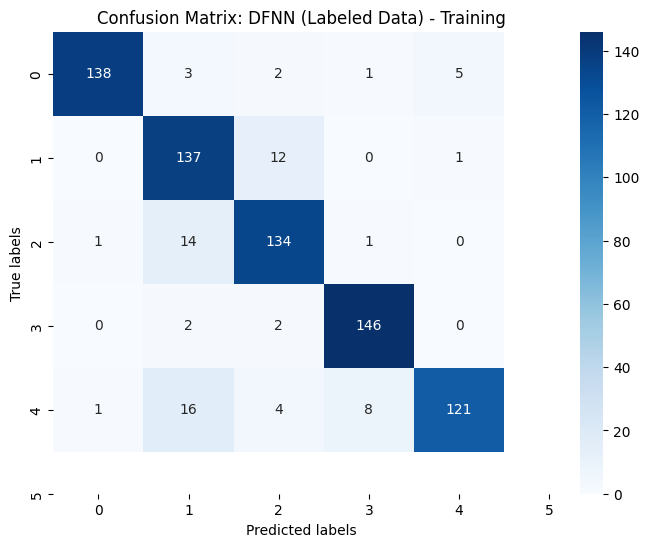

C:\Users\Shreyas_new_laptop\AppData\Local\Temp\ipykernel_24232\1414289484.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)


Confusion Matrix:
 [[32  3 10  6  3]
 [ 3 26 13  2  5]
 [ 5 16 21  3  8]
 [ 3 11  3 23  6]
 [ 0  7 17 11 12]]
Accuracy: 0.4578


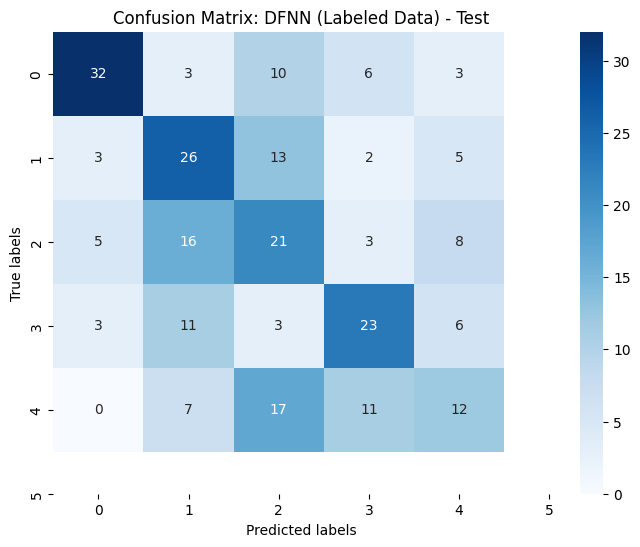

C:\Users\Shreyas_new_laptop\AppData\Local\Temp\ipykernel_24232\1414289484.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)


Confusion Matrix:
 [[27  5  7  4  2]
 [ 4 27  9  5  6]
 [ 6 12 14  7  8]
 [ 2  9  6 29  7]
 [ 1 13  9 12 18]]
Accuracy: 0.4618


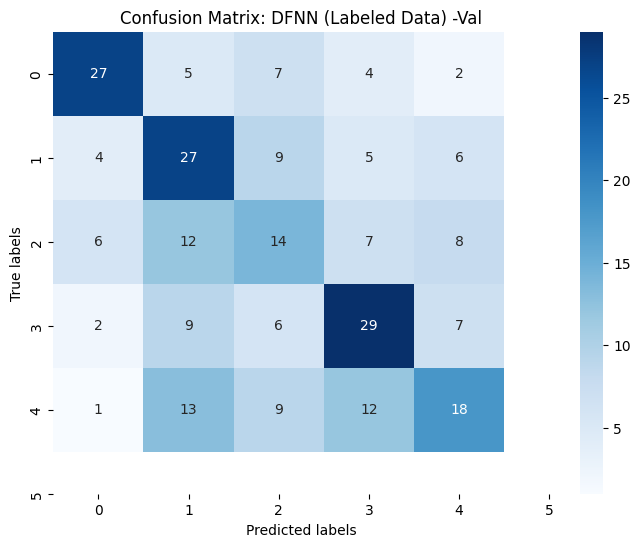

0.46184738955823296

In [14]:

# Evaluate on Training & Test Sets
class_names = [0,1,2,3,4,5]
evaluate_model(dfnn_model, X_train_labeled, y_train_labels, "DFNN (Labeled Data) - Training",class_names)
evaluate_model(dfnn_model, X_test, y_test_labels, "DFNN (Labeled Data) - Test",class_names)
evaluate_model(dfnn_model, X_val, y_val_labels, "DFNN (Labeled Data) -Val", class_names)

C:\Users\Shreyas_new_laptop\AppData\Local\Temp\ipykernel_24232\1414289484.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)


Confusion Matrix:
 [[109  10  17   1  12]
 [  1  95  22   5  27]
 [  8  13 106   2  21]
 [  5  10   0  78  57]
 [  2  10  13   4 121]]
Accuracy: 0.6796


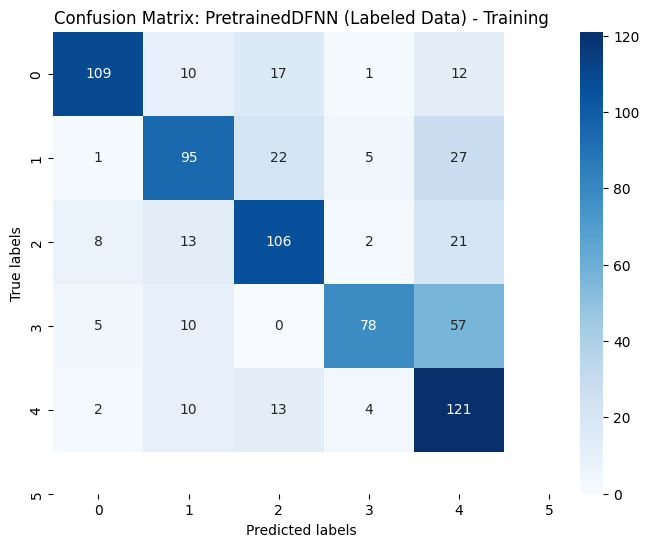

C:\Users\Shreyas_new_laptop\AppData\Local\Temp\ipykernel_24232\1414289484.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)


Confusion Matrix:
 [[36  3  2  2 11]
 [ 0 19 18  1 11]
 [ 6  7 24  2 14]
 [ 0  3  2 18 23]
 [ 2  4  7  2 32]]
Accuracy: 0.5181


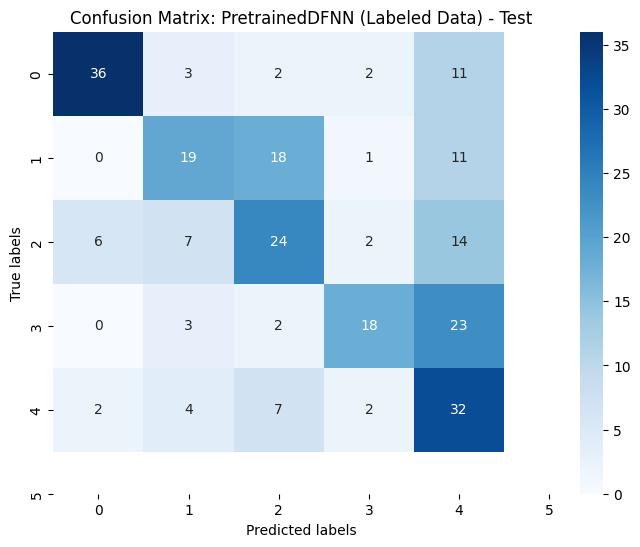

C:\Users\Shreyas_new_laptop\AppData\Local\Temp\ipykernel_24232\1414289484.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)


Confusion Matrix:
 [[32  3  6  2  2]
 [ 1 24  6  3 17]
 [ 6  8 13  2 18]
 [ 1  1  3 19 29]
 [ 1  2  8  3 39]]
Accuracy: 0.5100


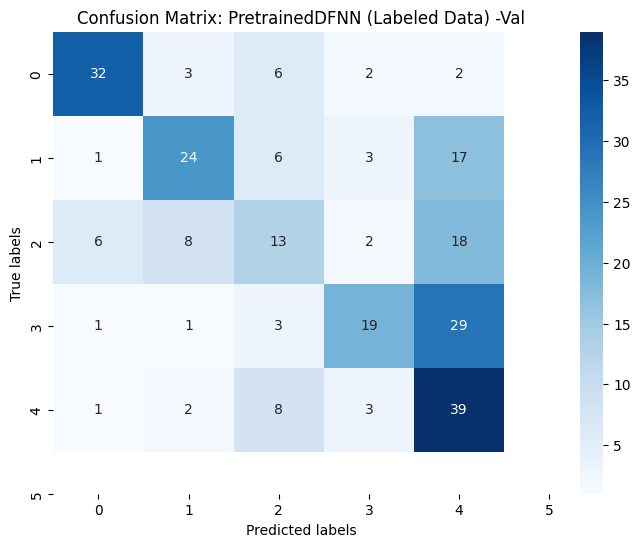

0.5100401606425703

In [15]:
# Evaluate on Training & Test Sets
evaluate_model(pretrained_model, X_train_labeled, y_train_labels, "PretrainedDFNN (Labeled Data) - Training",class_names)
evaluate_model(pretrained_model, X_test, y_test_labels, "PretrainedDFNN (Labeled Data) - Test",class_names)
evaluate_model(pretrained_model, X_val, y_val_labels, "PretrainedDFNN (Labeled Data) -Val", class_names)